<a href="https://colab.research.google.com/github/TehJimmmyy/SentimentalAnalysis/blob/main/Hate_Speech_Trainer_2e_5_8_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning==1.2.8 --quiet
!pip install transformers --quiet

     |████████████████████████████████| 841 kB 11.1 MB/s 
     |████████████████████████████████| 829 kB 49.2 MB/s 
     |████████████████████████████████| 282 kB 47.1 MB/s 
     |████████████████████████████████| 119 kB 49.8 MB/s 
     |████████████████████████████████| 269 kB 41.0 MB/s 
     |████████████████████████████████| 1.3 MB 36.7 MB/s 
     |████████████████████████████████| 142 kB 46.2 MB/s 
     |████████████████████████████████| 294 kB 50.3 MB/s 
     |████████████████████████████████| 2.8 MB 11.1 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 3.3 MB 37.3 MB/s 
     |████████████████████████████████| 895 kB 31.8 MB/s 


In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-09accfb4-fd99-7087-f2ad-e71ce1b8f618)


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [ ]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
68.8MB [00:00, 75.1MB/s]


In [ ]:
dataframe = pd.read_csv("toxic_comments.csv")
dataframe.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
def label_speech (row):
   if row['toxic'] + row['severe_toxic'] + row['obscene'] + row['threat'] + row['insult'] + row['identity_hate'] >= 1 :
      return 1
   return 0

In [ ]:
dataframe['Hate_Speech'] = dataframe.apply (lambda row: label_speech(row), axis=1)

In [ ]:
dataframe.head(n=7)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Hate_Speech
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1


In [ ]:
class_names = ['Clean', 'Hate_Speech']
LABEL_COLUMNS = dataframe.columns.tolist()[8:]
LABEL_COLUMNS

['Hate_Speech']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


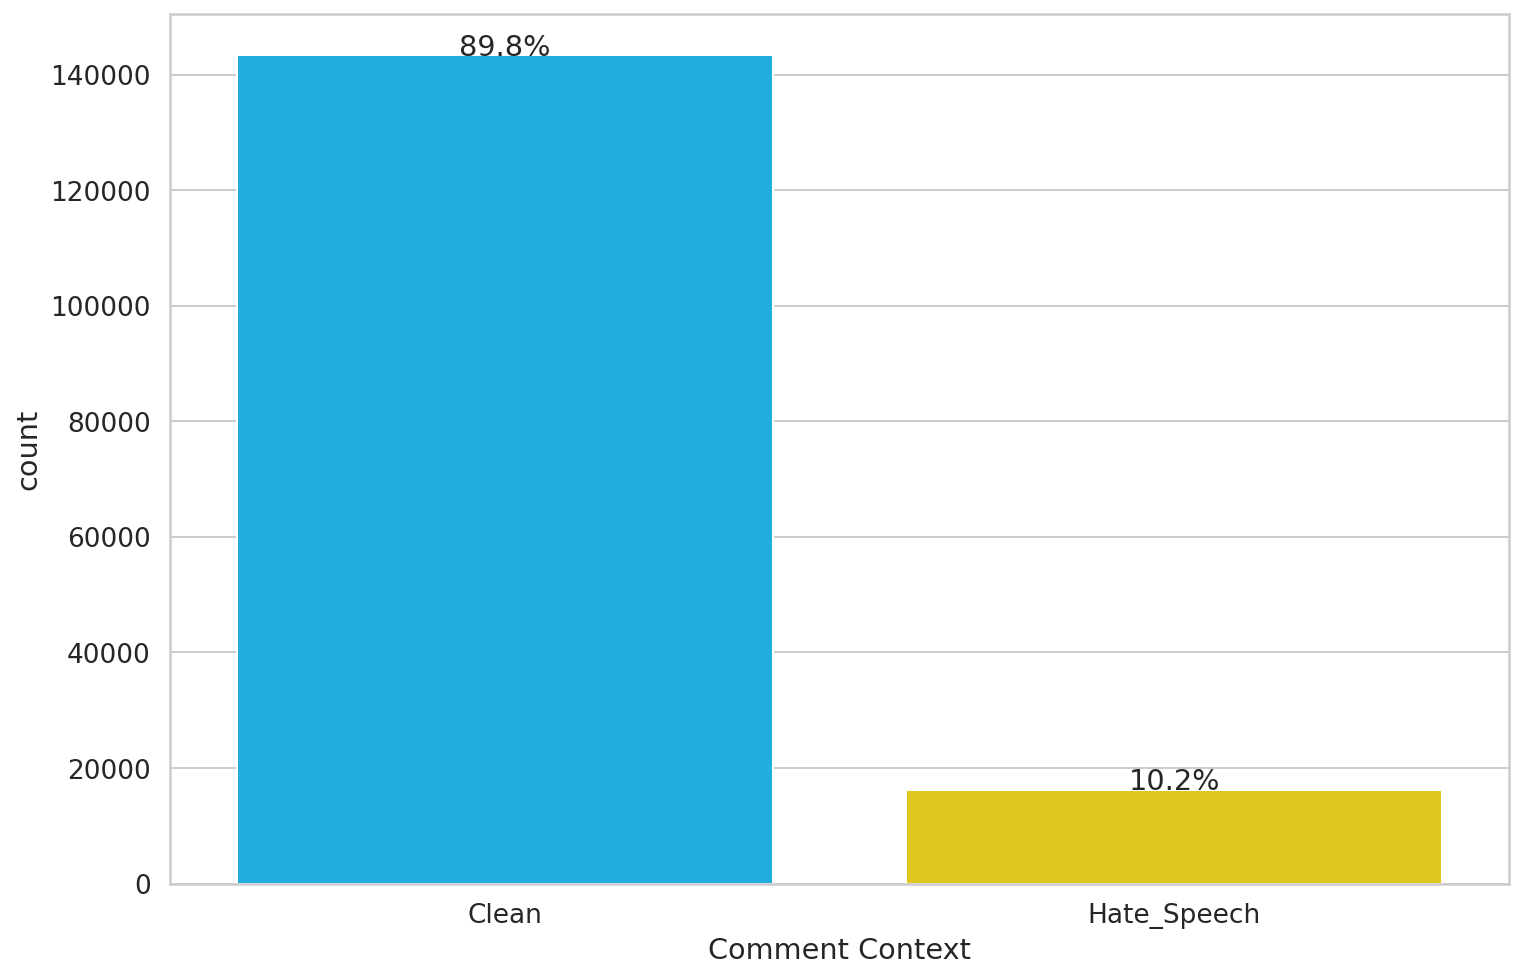

In [ ]:
ax = sns.countplot(dataframe.Hate_Speech)
plt.xlabel('Comment Context')
ax.set_xticklabels(class_names);

total = float(len(dataframe))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() - 0.4 + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [ ]:
train_toxic = dataframe[dataframe['Hate_Speech'] == 1]
train_clean = dataframe[dataframe['Hate_Speech'] == 0]

In [ ]:
train_toxic

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Hate_Speech
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,1
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,1
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,1


In [ ]:
train_dataframe = pd.concat([
  train_toxic,
  train_clean.sample(16_225)
])

train_dataframe, validation_dataframe = train_test_split(train_dataframe, test_size=0.2)

validation_dataframe , test_dataframe = train_test_split(validation_dataframe,test_size=0.5)


train_dataframe.shape, validation_dataframe.shape , test_dataframe.shape

((25960, 9), (3245, 9), (3245, 9))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


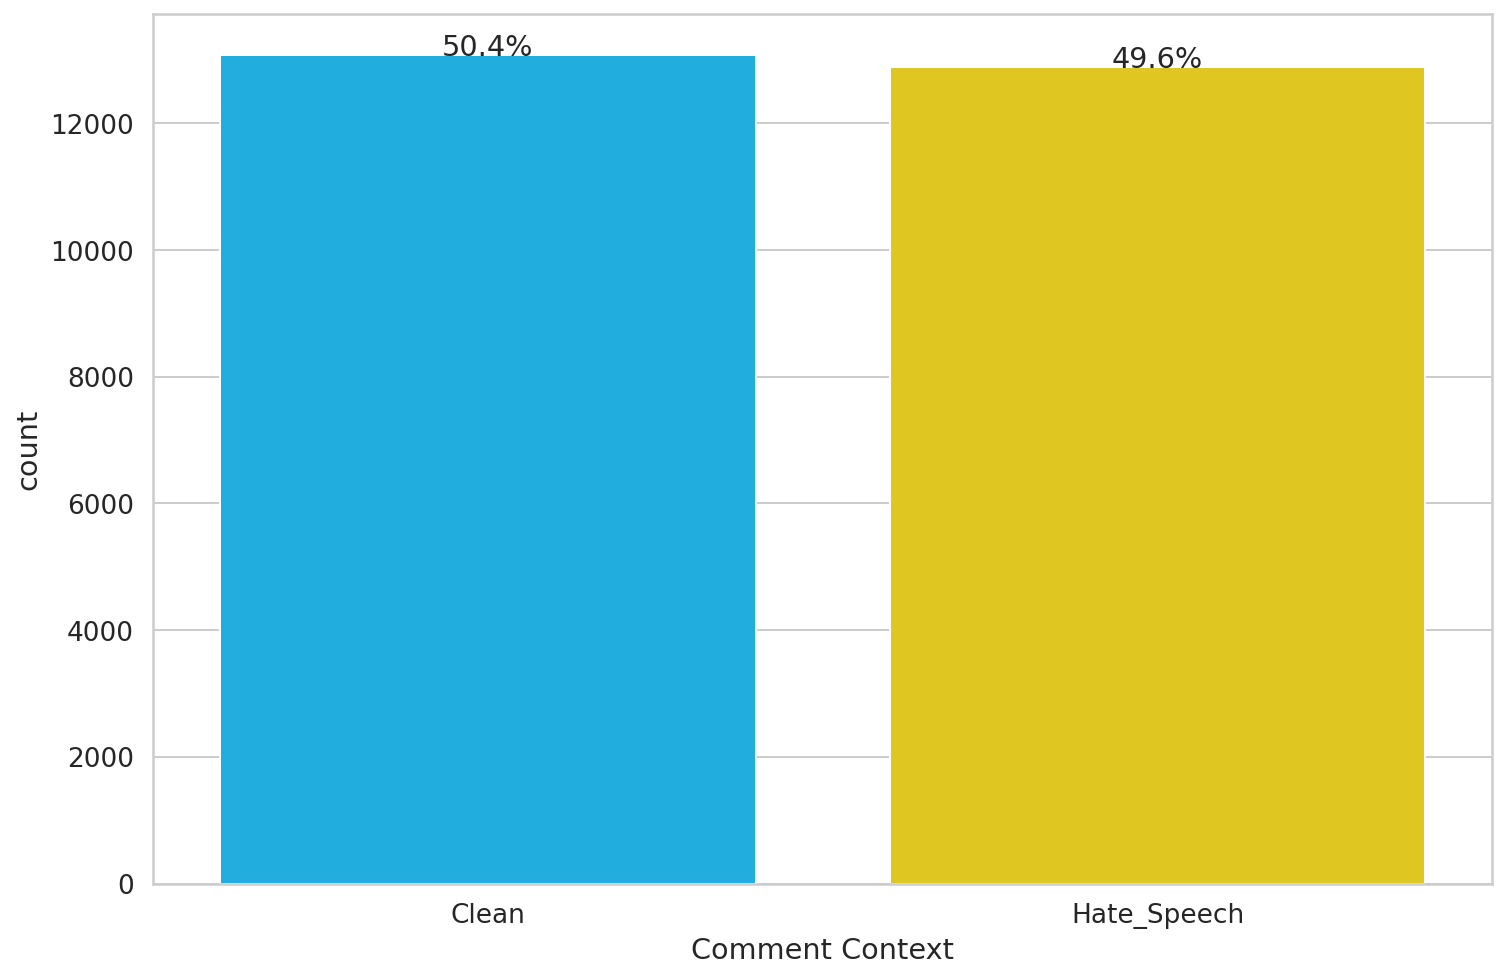

In [ ]:
ax = sns.countplot(train_dataframe.Hate_Speech)
plt.xlabel('Comment Context')
ax.set_xticklabels(class_names);

total = float(len(train_dataframe))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() - 0.4 + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_counts = []

for _, row in train_dataframe.iterrows():
  token_count = len(tokenizer.encode(
    row["comment_text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

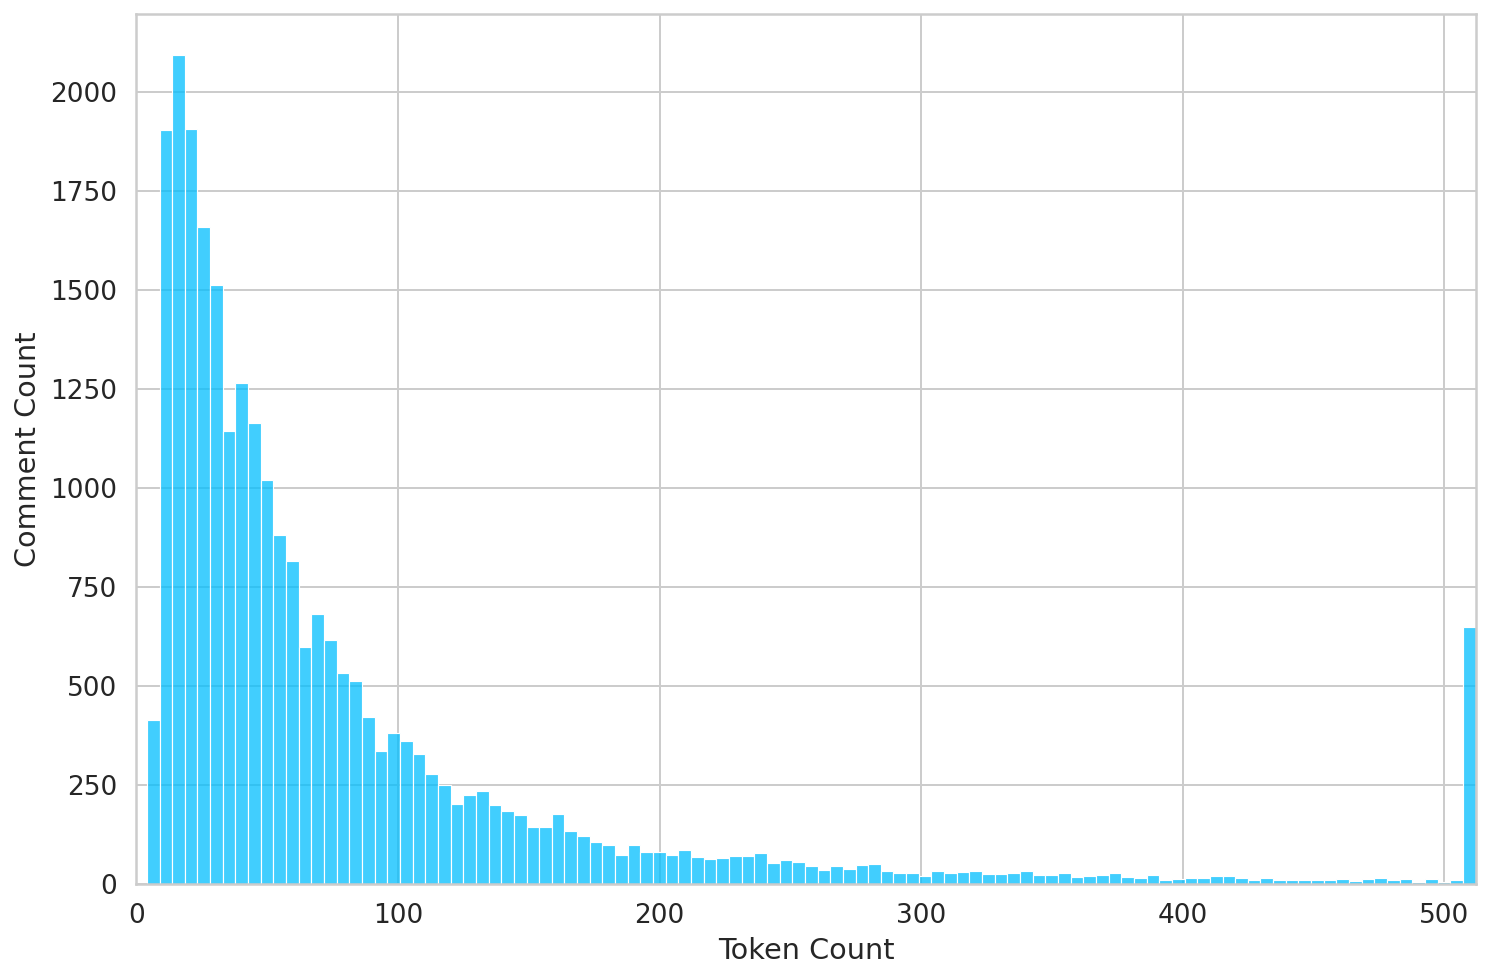

In [ ]:
sns.histplot(token_counts)
plt.xlabel('Token Count')
plt.ylabel('Comment Count')
plt.xlim([0, 512]);

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class HateSpeechDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
class HateSpeechDataModule(pl.LightningDataModule):

  def __init__(self, train_dataframe, validation_dataframe, test_dataframe, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_dataframe = train_dataframe
    self.validation_dataframe = validation_dataframe
    self.test_dataframe = test_dataframe
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = HateSpeechDataset(
      self.train_dataframe,
      self.tokenizer,
      self.max_token_len
    )

    self.validation_dataset = HateSpeechDataset(
      self.validation_dataframe,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = HateSpeechDataset(
      self.test_dataframe,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.validation_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 8

data_module = HateSpeechDataModule(
  train_dataframe,
  validation_dataframe,
  test_dataframe,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class HateSpeechTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    validation_acc = accuracy(predictions, labels)
    self.logger.experiment.add_scalar("Validation Accuracy", validation_acc, self.current_epoch)

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)


    class_roc_auc = auroc(predictions, labels)
    self.logger.experiment.add_scalar("Hate Speech ROC Curve/Train", class_roc_auc, self.current_epoch)

    training_acc = accuracy(predictions, labels)
    self.logger.experiment.add_scalar("Training Accuracy", training_acc, self.current_epoch)




  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
steps_per_epoch=len(train_dataframe) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS


warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(6490, 32450)

In [ ]:
model = HateSpeechTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training and Logging


In [ ]:
!mkdir TrainModels

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="TrainModels",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, data_module)

In [ ]:
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
!cp /content/TrainModels/best-checkpointHS2e-58batch2warmup.ckpt /content/drive/MyDrive


Mounted at /content/drive


In [ ]:
!cp -av /content/lightning_logsHS2e-58batch2warmup/ /content/drive/MyDrive

'/content/lightning_logsHS2e-58batch2warmup/' -> '/content/drive/MyDrive/lightning_logsHS2e-58batch2warmup'
'/content/lightning_logsHS2e-58batch2warmup/toxic-comments' -> '/content/drive/MyDrive/lightning_logsHS2e-58batch2warmup/toxic-comments'
'/content/lightning_logsHS2e-58batch2warmup/toxic-comments/version_0' -> '/content/drive/MyDrive/lightning_logsHS2e-58batch2warmup/toxic-comments/version_0'
'/content/lightning_logsHS2e-58batch2warmup/toxic-comments/version_0/events.out.tfevents.1631272804.55cc01d5f50c.75.0' -> '/content/drive/MyDrive/lightning_logsHS2e-58batch2warmup/toxic-comments/version_0/events.out.tfevents.1631272804.55cc01d5f50c.75.0'
'/content/lightning_logsHS2e-58batch2warmup/toxic-comments/version_0/hparams.yaml' -> '/content/drive/MyDrive/lightning_logsHS2e-58batch2warmup/toxic-comments/version_0/hparams.yaml'
'/content/lightning_logsHS2e-58batch2warmup/toxic-comments/version_0/events.out.tfevents.1631282850.55cc01d5f50c.75.1' -> '/content/drive/MyDrive/lightning_logs

In [ ]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.16113406419754028}
--------------------------------------------------------------------------------


[{'test_loss': 0.16113406419754028}]

In [ ]:
#!gdown --id 1xRdoSajLQB2tBEs4KikQ5KrhLajNurQj #scalars
#!gdown --id 1-5eq6I5WGB6FMKJCPSQ6jwBMwyrmlaVq #hparams

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

In [ ]:
trained_model = HateSpeechTagger.load_from_checkpoint(
  '/content/TrainModels/best-checkpoint.ckpt',
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
THRESHOLD = 0.7

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

test_dataset = HateSpeechDataset(
  test_dataframe,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/3245 [00:00<?, ?it/s]

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9202)

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

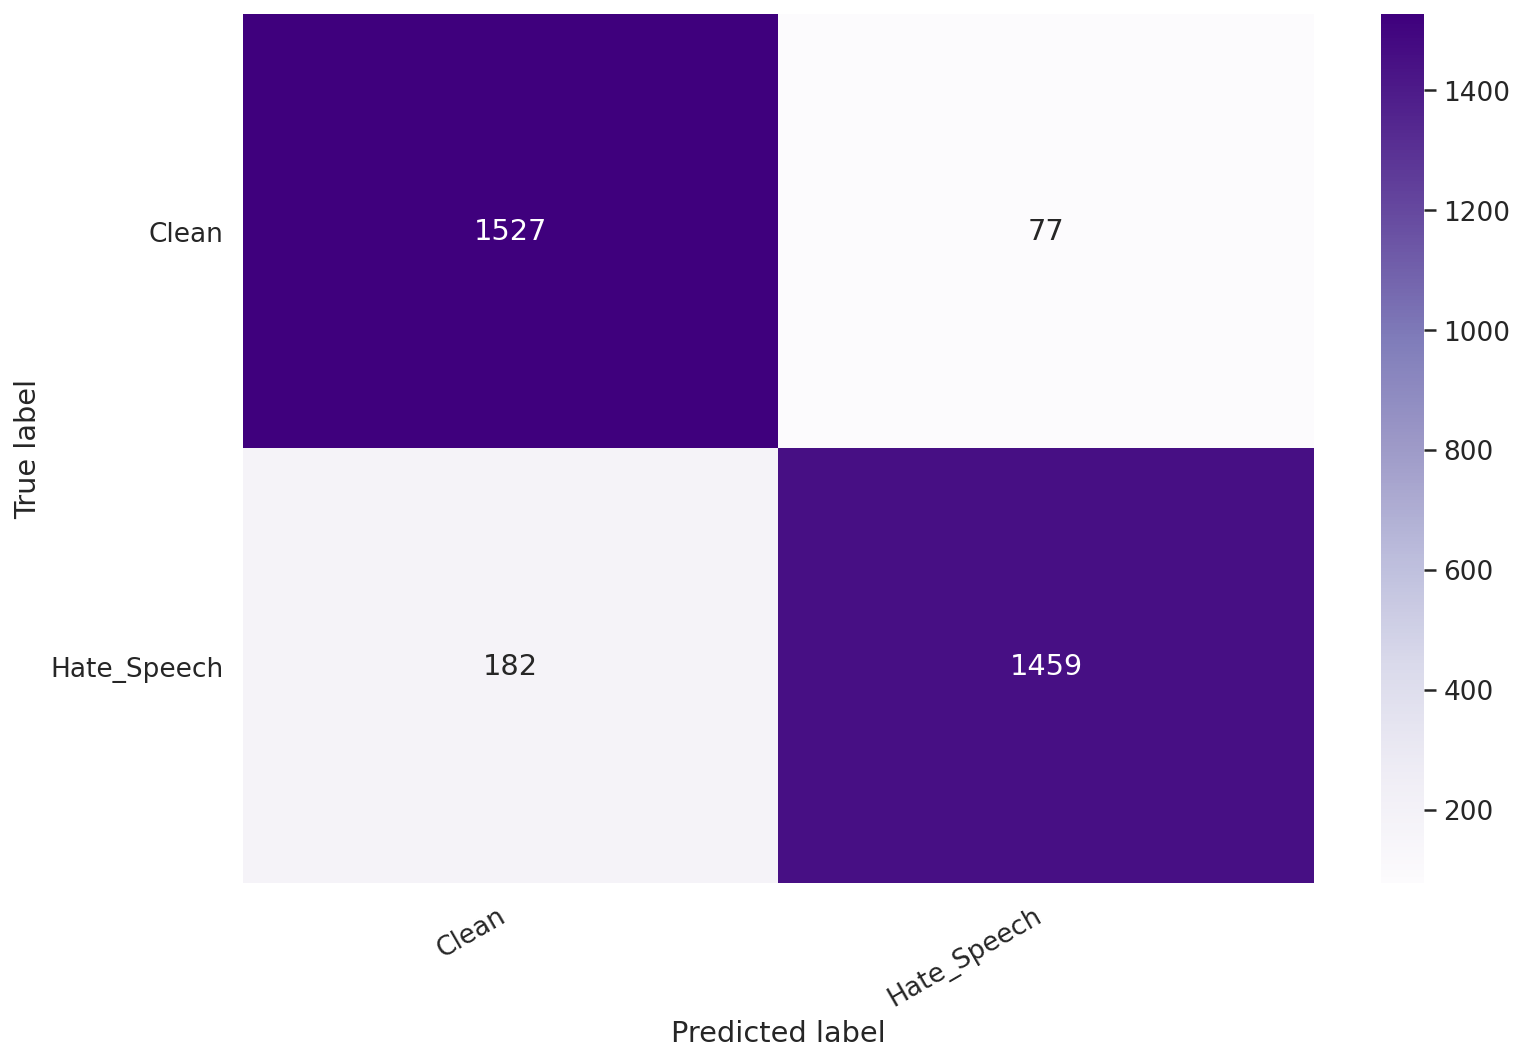

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Purples")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');

cm = confusion_matrix(y_true, y_pred)
dataframe_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(dataframe_cm)